In [51]:
import cv2
import os
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import csv
import pandas as pd
import keras
from keras import models,Model
from keras.layers import Dense,GaussianNoise, Dropout,Input
from keras.utils import np_utils
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
%matplotlib inline
from skimage.feature import hog
%matplotlib inline 
from sklearn.cluster import KMeans


In [52]:
dataSet = []
person = []
horiSet = []
train_set_x = []
count = 0
folder = "/home/jeet/ML face images train"
for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
#         print(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (200,200))
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(img,None)
        kmeans = KMeans(n_clusters=1, random_state=0).fit(des)
#         print(kmeans.cluster_centers_.shape)
        train_set_x.append(kmeans.cluster_centers_)
#         person.append(numbers[0])
        img = np.ravel(img)
        if img is not None:
#             for desc in des: 
            numbers = re.findall('\d+',filename)
            numbers = list(map(int,numbers))
            person.append(numbers[0])
            horiSet.append(img.T)
#             dataSet.append(desc)
            count = count + 1

print(np.array(train_set_x).shape)      
dataSet_test = []
person_test = []
horiSet_test = []
test_set_x = []
folder = "/home/jeet/ML face images test"
for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (200, 200))
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(img,None)
        #kp will be a list of keypoints and des is a numpy array of shape Number_of_Keypoints×128.
        kmeans = KMeans(n_clusters=1, random_state=0).fit(des)
        test_set_x.append(kmeans.cluster_centers_)
        img = np.ravel(img)
        if img is not None:
#             for desc in des: 
            numbers = re.findall('\d+',filename)
            numbers = list(map(int,numbers))
            person_test.append(numbers[0])
            horiSet_test.append(img.T)
#             dataSet_test.append(desc)
            count = count + 1
print(np.array(test_set_x).shape , np.array(person_test).shape)

(418, 1, 128)
(140, 1, 128) (140,)


In [53]:
train_set_x = np.reshape(train_set_x,(418,128))
test_set_x = np.reshape(test_set_x,(140,128))

In [54]:
#Getting data in desired format and mapping the lables
dataSet = np.array(train_set_x)
train = pd.DataFrame(dataSet)

person = np.array(person)
train['id'] = person.transpose()

unique_person = train['id']
unique_person = np.array(unique_person)
unique_person = np.unique(unique_person)
key = range(len(unique_person))

roll_dict = dict( zip(unique_person, key))

mapped_roll = np.vectorize(roll_dict.get)(person)
train['id'] = mapped_roll.transpose()

y = train['id'].values.astype('int64')
images = train.drop(['id'], axis=1, inplace=False)
x = (images.values).astype('uint8')

X_train = x
Y_train = y

dataSet_test = np.array(test_set_x)
test = pd.DataFrame(dataSet_test)

person_test = np.array(person_test)
test['id'] = person_test.transpose()

mapped_roll_test = np.vectorize(roll_dict.get)(person_test)
test['id'] = mapped_roll_test.transpose()
print(test['id'])

temp = np_utils.to_categorical(test['id'])
print(temp[2])
print(temp.shape)

temp = np_utils.to_categorical(test['id'])
print(temp[2])
print(temp.shape)

y_test = test['id'].values.astype('int64')
images = test.drop(['id'], axis=1, inplace=False)
x_test = (images.values).astype('uint8')

X_test = x_test
Y_test = y_test

0      29
1      32
2       4
3      14
4      34
5      35
6      25
7      29
8       6
9      18
10     25
11     19
12     21
13     24
14     28
15     33
16     10
17      2
18      7
19      9
20     23
21     31
22     15
23     12
24      6
25     21
26     20
27      8
28     26
29     34
       ..
110    35
111    31
112    15
113    23
114    17
115     9
116    33
117    19
118    26
119    33
120    23
121    18
122    27
123    14
124    10
125     0
126    20
127    31
128     6
129    17
130    34
131     8
132    35
133    26
134    18
135     6
136    30
137    14
138     9
139    13
Name: id, Length: 140, dtype: int64
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(140, 36)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(140, 36)


In [60]:
#Defining and training of the neural neural network
model = models.Sequential()
layers = 2
units = 256

#Input layer
model.add(Dense(units, input_dim=128, activation='relu'))

#Hidden Layer
for i in range(layers):
    model.add(Dense(146, activation='relu'))
    model.add(Dropout(0.1))
    
#Output layer
model.add(Dense(36, activation='softmax'))

#Building model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#Training model
model.fit(X_train,Y_train,batch_size=70,validation_split=0.2,epochs=150,verbose=2)

Train on 334 samples, validate on 84 samples
Epoch 1/150
 - 1s - loss: 14.9370 - acc: 0.0269 - val_loss: 14.8921 - val_acc: 0.0238
Epoch 2/150
 - 0s - loss: 14.9536 - acc: 0.0299 - val_loss: 14.2428 - val_acc: 0.0000e+00
Epoch 3/150
 - 0s - loss: 14.3180 - acc: 0.0479 - val_loss: 13.2246 - val_acc: 0.0595
Epoch 4/150
 - 0s - loss: 13.7543 - acc: 0.0479 - val_loss: 12.0264 - val_acc: 0.0238
Epoch 5/150
 - 0s - loss: 11.1057 - acc: 0.0449 - val_loss: 5.6070 - val_acc: 0.0952
Epoch 6/150
 - 0s - loss: 5.7164 - acc: 0.0479 - val_loss: 4.0682 - val_acc: 0.0595
Epoch 7/150
 - 0s - loss: 4.0617 - acc: 0.0569 - val_loss: 3.6125 - val_acc: 0.0476
Epoch 8/150
 - 0s - loss: 3.4884 - acc: 0.0778 - val_loss: 3.6160 - val_acc: 0.0476
Epoch 9/150
 - 0s - loss: 3.4082 - acc: 0.0928 - val_loss: 3.5947 - val_acc: 0.0476
Epoch 10/150
 - 0s - loss: 3.3494 - acc: 0.1018 - val_loss: 3.5726 - val_acc: 0.0595
Epoch 11/150
 - 0s - loss: 3.2667 - acc: 0.1527 - val_loss: 3.4878 - val_acc: 0.0595
Epoch 12/150
 - 

Epoch 97/150
 - 0s - loss: 0.8535 - acc: 0.7485 - val_loss: 2.3777 - val_acc: 0.4048
Epoch 98/150
 - 0s - loss: 0.8015 - acc: 0.7096 - val_loss: 2.3906 - val_acc: 0.3929
Epoch 99/150
 - 0s - loss: 0.7694 - acc: 0.7605 - val_loss: 2.4674 - val_acc: 0.3333
Epoch 100/150
 - 0s - loss: 0.7554 - acc: 0.7725 - val_loss: 2.4680 - val_acc: 0.3929
Epoch 101/150
 - 0s - loss: 0.7720 - acc: 0.7515 - val_loss: 2.3926 - val_acc: 0.4286
Epoch 102/150
 - 0s - loss: 0.7051 - acc: 0.7964 - val_loss: 2.3298 - val_acc: 0.4405
Epoch 103/150
 - 0s - loss: 0.7457 - acc: 0.7874 - val_loss: 2.4596 - val_acc: 0.4048
Epoch 104/150
 - 0s - loss: 0.7244 - acc: 0.7695 - val_loss: 2.5919 - val_acc: 0.3214
Epoch 105/150
 - 0s - loss: 0.7261 - acc: 0.7784 - val_loss: 2.4836 - val_acc: 0.4167
Epoch 106/150
 - 0s - loss: 0.8180 - acc: 0.7305 - val_loss: 2.4374 - val_acc: 0.3690
Epoch 107/150
 - 0s - loss: 0.7285 - acc: 0.7695 - val_loss: 2.3724 - val_acc: 0.3690
Epoch 108/150
 - 0s - loss: 0.7088 - acc: 0.7814 - val_lo

In [61]:
predictions = model.predict_classes(X_test, verbose=0)

def write_predictions(predictions, fname):
    pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "id": predictions}).to_csv(fname, index=False, header=True)

write_predictions(predictions, "out.csv")


In [62]:
result = pd.read_csv('out.csv')
result = result['id']
result = np.array(result)
error = np.array(Y_test - result)
error = error[error != 0]
error = error.size/Y_test.size

print('Accuracy : ',1-error)

result

Accuracy :  0.5285714285714286


array([ 6, 16, 26,  4, 34, 35,  4, 29, 10, 26, 25, 19, 21, 24, 26, 10, 13,
        2, 12, 31, 24, 33, 15, 12, 10, 22, 20,  7, 14, 34, 16,  4, 22,  1,
       30, 10,  1, 15, 29, 16,  0, 21, 15,  1, 13, 16, 25, 33,  0, 25, 32,
       29, 19,  9, 26, 34, 24, 18, 25, 26,  0, 12,  0, 30, 26, 25,  3, 24,
       34,  1, 20, 12, 19, 13, 25, 16, 35,  8, 19,  1,  3,  3,  3, 20, 21,
        2, 22,  0, 32, 22,  3,  7,  0, 16,  6,  7, 25, 12, 14,  0, 30, 20,
       31,  8, 13, 14,  0,  9,  4, 34, 35,  4, 22, 23, 17,  7,  1, 19, 26,
       35, 32, 17, 27, 14, 10,  0, 24, 25,  6,  6, 34,  0, 35, 30, 18,  6,
       30, 12, 10,  1])

In [63]:
score = model.predict_proba(X_test)

Average precision score, micro-averaged over all classes: 0.59


/home/jeet/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


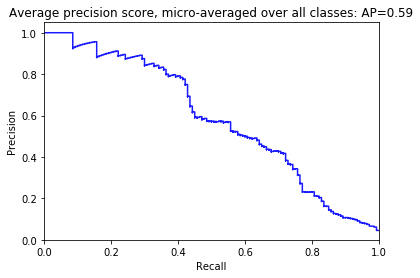

In [75]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(36):
    precision[i], recall[i], _ = precision_recall_curve(temp[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(temp[:, i], score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(temp.ravel(),
    score.ravel())
average_precision["micro"] = average_precision_score(temp, score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

fig = plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.9,
         where='post')
#plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
#                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.show()
fig.savefig('SIFT-ANN.png',dpi=100)